In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from scipy.integrate import quad

import seaborn as sns
from scipy import stats
from scipy.stats import truncnorm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import torch
import torch.nn as nn
import torch.optim as optim
#import torchvision
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
#import torchinfo

import warnings
import os
from copy import deepcopy

import plotting
import dataset_fctns
import modelling_fctns
from ML_fctns import *

from datetime import datetime
from dateutil.relativedelta import relativedelta
#from suntimes import SunTimes  
import sys
sys.path.append("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\optimisation_experiments")
from optimise_GDD_fctns import *
from nn_response_fctns import *

c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
C:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\optimisation_experiments\optimise_GDD_fctns.py:34: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [2]:
skip = 1
numsteps = int(163 // skip)
#ds_inputs_DE1 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_2001_2024_full.csv')
#ds_inputs_DE1[[f't2max at day {skip*n}' for n in range(numsteps)]] += -273.15
#ds_inputs_DE1[[f't2min at day {skip*n}' for n in range(numsteps)]] += -273.15
#ds_inputs_DE2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_90s.csv')

#ds_inputs_DE = pd.concat([ds_inputs_DE1, ds_inputs_DE2], axis = 0)
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_full.csv')
#ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE=ds_inputs_DE.rename(columns={'Referenzjahr':'year'})
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.dropna(how='all')
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] < 140]
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] > 40]
new_series = []
ds_inputs_DE.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]] = ds_inputs_DE.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]].values - ds_inputs_DE.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values
ds_inputs_DE.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]] = ds_inputs_DE.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values - ds_inputs_DE.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]].values
for variable_name in ['t2m', 't2max', 't2min', 'photoperiod', 'vpd']: #, 'ssrd', 'tp'
    data = ds_inputs_DE[[f'{variable_name} at day {skip*n}' for n in range(numsteps)]].values
    #if variable_name != 't2m' and variable_name != 'photoperiod':
    #    scaler = StandardScaler()
    #    scaler.fit(data)
    #    data = scaler.transform(data)
    new_variable_series = torch.Tensor(data)
    new_series.append(new_variable_series)

day_series_DE = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds_inputs_DE))])
year_series_DE = torch.Tensor([ds_inputs_DE['year'].values for count in range(numsteps)]).T
id_series_DE = torch.Tensor([ds_inputs_DE['Stations_id'].values for count in range(numsteps)]).T
temp_NDVI_series_DE = torch.swapaxes(torch.stack((*new_series, day_series_DE, year_series_DE, id_series_DE)), 0, 1)
ds_inputs_DE.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds_inputs_DE['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds_inputs_DE),1))
NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)

#NDVI_labels_DE = torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype(int).values).unsqueeze(1)
#NDVI_labels_DE = 100 - torch.Tensor(ds_inputs_DE[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values)

27153
27153


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_16836\356867199.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_34s6o8i12c\croot\libtorch_1751464457133\work\torch\csrc\utils\tensor_new.cpp:257.)
  year_series_DE = torch.Tensor([ds_inputs_DE['year'].values for count in range(numsteps)]).T


In [ ]:
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_ERA5_1999_2008_with_varieties_fixed_vpd.csv')
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] < 105]
#ds_vpd = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_SSA_vpd_varieties_fixed.csv')
#ds_inputs_SSA = ds_inputs_SSA.drop(columns=[f'vpd at day {n}' for n in range(200)])
#ds_inputs_SSA = ds_inputs_SSA.merge(ds_vpd.drop(columns = ['Unnamed: 0', 'WC SOS date', 'observed time to beginning of flowering']), on = ['Stations_id', 'lat', 'lon', 'Management', 'vargroup', 'Referenzjahr'])
#ds_inputs_SSA = ds_inputs_SSA.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'])
#ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_full.csv')
#ds_inputs_SSA.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_ERA5_1999_2008_with_varieties_fixed_vpd.csv')

In [38]:
def forward_NN_KG2(self, x0):
    with torch.no_grad():
        T_min = 9 + 10*(torch.tanh(self.u1)) - 4 #normally multiplier = 2
        T_opt = 28 + 7*(torch.tanh(self.u2)) - 4 #normally multiplier = 3
        T_max = 39 + 3.5*torch.tanh(self.u3)#normally no multiplier
        #print(T_min)
        alpha = np.log(2)/torch.log( (T_max - T_min)/(T_opt - T_min) )
        original_temp = x0[:, :, [0]]
        x2 = x0[:, :, [0]]
        x2[:, :, 0] = (x2[:, :, 0] <= T_max) * ( (2*(((x2[:, :, 0] - T_min)*(x2[:, :, 0] >= T_min) + (x2[:, :, 0] <= T_min).float()).pow(alpha))*(x2[:, :, 0] >= T_min))*((T_opt - T_min).pow(alpha)) - ((((x2[:, :, 0] - T_min)*(x2[:, :, 0] >= T_min) + (x2[:, :, 0] <= T_min).float()).pow(2*alpha))*(x2[:, :, 0] >= T_min)) ) / ((T_opt - T_min).pow(2*alpha))
        x = x0[:, :, :self.input_dim]
        for linlayer in self.layers_list[:self.num_layers]:
            x = linlayer(x)
            x = self.activation(x)
        out_space = self.u4*(torch.abs(self.fc(x) + x2)*(original_temp >5))# - x2#*(x[:, :, [0]] >5) # (batch, output_dim)
        #out_space = self.u4*(torch.abs(self.fc(x))*(original_temp >5))
    #print(out_scores.max())
    return out_space

In [61]:
def split_ds_by_AEZ5(ds):
    ds_semiarid_low = ds.loc[ds['AEZ'].isin([1])].groupby(['Stations_id', 'year']).head(2)
    ds_arid_low = ds.loc[ds['AEZ'].isin([26, 29])].groupby(['Stations_id', 'year']).head(2)
    ds_subhumid_low = ds.loc[ds['AEZ'].isin([2])].groupby(['Stations_id', 'year']).head(2)
    ds_humid_low = ds.loc[ds['AEZ'].isin([3])].groupby(['Stations_id', 'year']).head(2)
    ds_arid_high = ds.loc[ds['AEZ'].isin([4])].groupby(['Stations_id', 'year']).head(2)
    ds_humid_high = ds.loc[ds['AEZ'].isin([5])].groupby(['Stations_id', 'year']).head(2)
    ds_cool = ds.loc[ds['AEZ'].isin([10, 11, 14])].groupby(['Stations_id', 'year']).head(2)
    print(#f'\nnum cool: {len(ds_cool)}',
        f'\nnum semiarid low: {len(ds_semiarid_low)}',
        f'\nnum arid high: {len(ds_arid_high)}',
        f'\nnum humid low: {len(ds_humid_low)}',
        f'\nnum subhumid low: {len(ds_subhumid_low)}',
        f'\nnum subhumid high: {len(ds_humid_high)}')
    ds_dict = {#'cool': ds_cool,
               'semiarid low': ds_semiarid_low,
               'arid high': ds_arid_high,
               'humid low': ds_humid_low,
               'subhumid low': ds_subhumid_low,
               'humid high': ds_humid_high}
    return ds_dict

ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_ERA5_1999_2008_with_varieties_fixed_vpd.csv')
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] < 105]
#ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] > 20]
ds_sites_AEZ2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Lobell2011\\EIL_site_latlon_with_AEZ_filled.csv')
ds_inputs_SSA = ds_inputs_SSA.merge(ds_sites_AEZ2.rename(columns = {'LocationID': 'Stations_id'})[['Stations_id', 'AEZ2']], on='Stations_id', how='left')
ds_inputs_SSA['AEZ'] = ds_inputs_SSA['AEZ2']
ds_inputs_SSA = ds_inputs_SSA.rename(columns={'Referenzjahr': 'year'})
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['lat'] > -25]

ds_SSA_early = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'EPOP')|(ds_inputs_SSA['vargroup'] == 'EIHY')].reset_index().drop(columns=['Unnamed: 0'])#, 'Unnamed: 0.1'])
early_ds_dict = split_ds_by_AEZ5(ds_SSA_early)

ds_SSA_late = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'ILPO')|(ds_inputs_SSA['vargroup'] == 'ILHY')].reset_index().drop(columns=['Unnamed: 0'])#, 'Unnamed: 0.1'])
late_ds_dict = split_ds_by_AEZ5(ds_SSA_late)

combined_variety_tests_dict = {key: pd.concat((early_ds_dict[key], late_ds_dict[key])) for key in early_ds_dict.keys()}

X_tensor_train, y_tensor_train = ML_tensor_from_ds(combined_variety_tests_dict['semiarid low'])


num semiarid low: 120 
num arid high: 59 
num humid low: 26 
num subhumid low: 67 
num subhumid high: 45

num semiarid low: 101 
num arid high: 50 
num humid low: 17 
num subhumid low: 68 
num subhumid high: 46


In [76]:
train_dl, val_dl = train_test_dl_by_year(temp_NDVI_series_DE, NDVI_labels_DE, test_years = [2023, 2024], year_column = -2, bs = 30000, n_channels = n_channels, train_proportion=0.8)
train_dl, val_dl = train_test_dl_from_tensors(X_tensor_train, y_tensor_train, bs = 30000, n_channels = n_channels, train_proportion=0.5)
n_channels = 5
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16#day2 -> 8#day -> 16 #day3 ->4
num_layers = 4#day3 -> 8
output_dim = 1  # Example: 5 classes
KG = False
KG2 = True
save_name = 'NN_response_DE_no_day5_more_epochs'
save_name = 'KFold1'
model= nn_temp_response(input_dim, hidden_dim, num_layers, output_dim, KG=KG, KG2=KG2)
model = load_model(save_name, model)

In [83]:
def get_shap_values(train_dl, val_dl, save_name):
    n_channels = 5
    input_dim = n_channels # Example: 100-dimensional word embeddings
    hidden_dim = 16#day2 -> 8#day -> 16 #day3 ->4
    num_layers = 4#day3 -> 8
    output_dim = 1  # Example: 5 classes
    KG = False
    KG2 = True
    model= nn_temp_response(input_dim, hidden_dim, num_layers, output_dim, KG=KG, KG2=KG2)
    model = load_model(save_name, model)
    def shap_wrapper(x):
        #print(torch.tensor(x).unsqueeze(0).unsqueeze(0).float())
        if x.ndim == 1:
            input_vec = torch.tensor(x).unsqueeze(0).unsqueeze(0).float()
            return np.expand_dims(np.expand_dims(forward_NN_KG2(model, input_vec).numpy().squeeze(), 0),0)#
        elif x.ndim == 2:
            input_vec = torch.tensor(x).unsqueeze(0).float()
            if x.shape[0] == 1:
                return np.expand_dims(np.expand_dims(forward_NN_KG2(model, input_vec).numpy().squeeze(), 0), 0)
            else:
                return np.expand_dims(forward_NN_KG2(model, input_vec).numpy().squeeze(), 1)
        else:
            input_vec = torch.tensor(x).float()
            return forward_NN_KG2(model, input_vec).numpy().squeeze()
    first = True
    for xb, yb in train_dl:
        if first:
            full_xb = xb
            first = False
        else:
            full_xb = torch.cat((full_xb, xb), dim=0)
    first = True
    for xb, yb in val_dl:
        if first:
            full_xb_val = xb
            first = False
        else:
            full_xb_val = torch.cat((full_xb_val, xb), dim=0)
    explainer = shap.KernelExplainer(shap_wrapper, 
                                 full_xb[[0, 25, 50, 75, 90], :].transpose(1, 2).flatten(0, 1)[:, :5].numpy(), 
                                 link="identity",
                                 feature_names=['t2m', 't2max', 't2min', 'photoperiod', 'vpd'])
    X_test =full_xb_val[[0, 25, 50, 75, 90], :].transpose(1, 2).flatten(0, 1)[:, :5].numpy()#[, :]
    shap_values = explainer.shap_values(X_test, nsamples=100)
    shap_data = pd.DataFrame(shap_values[:, :, 0], columns = ['t2m', 't2max\n-t2m', 't2m\n-t2min', 'photoperiod', 'vpd'])
    return shap_data

In [86]:
train_dl, val_dl = train_test_dl_by_year(temp_NDVI_series_DE, NDVI_labels_DE, test_years = [2023, 2024], year_column = -2, bs = 30000, n_channels = n_channels, train_proportion=0.8)
save_name = 'NN_response_DE_no_day5_more_epochs'
shap_data_DE = get_shap_values(train_dl, val_dl, save_name)

train_dl, val_dl = train_test_dl_from_tensors(X_tensor_train, y_tensor_train, bs = 30000, n_channels = n_channels, train_proportion=0.5)
save_name = 'semiarid_resp_TL1'
shap_data_SSA = get_shap_values(train_dl, val_dl, save_name)

Using 815 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 815/815 [00:04<00:00, 203.56it/s]
Using 815 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 815/815 [00:03<00:00, 206.50it/s]


In [87]:
import shap
def shap_wrapper(x):
    #print(torch.tensor(x).unsqueeze(0).unsqueeze(0).float())
    if x.ndim == 1:
        input_vec = torch.tensor(x).unsqueeze(0).unsqueeze(0).float()
        return np.expand_dims(np.expand_dims(forward_NN_KG2(model, input_vec).numpy().squeeze(), 0),0)#
    elif x.ndim == 2:
        input_vec = torch.tensor(x).unsqueeze(0).float()
        if x.shape[0] == 1:
            return np.expand_dims(np.expand_dims(forward_NN_KG2(model, input_vec).numpy().squeeze(), 0), 0)
        else:
            return np.expand_dims(forward_NN_KG2(model, input_vec).numpy().squeeze(), 1)
    else:
        input_vec = torch.tensor(x).float()
        return forward_NN_KG2(model, input_vec).numpy().squeeze()

#def shap_wrapper(x):
#    #print(torch.tensor(x).unsqueeze(0).unsqueeze(0).float())
#    if x.ndim == 1:
#        input_vec = torch.tensor(x).unsqueeze(0).unsqueeze(0).float()
#        return forward_NN_KG2(model, input_vec).numpy().squeeze()
#    elif x.ndim == 2:
#        input_vec = torch.tensor(x).unsqueeze(0).float()
#        if x.shape[0] == 1:
#            return forward_NN_KG2(model, input_vec).numpy().squeeze()
#        else:
#            return forward_NN_KG2(model, input_vec).numpy().squeeze()
#    else:
#        input_vec = torch.tensor(x).float()
#        return forward_NN_KG2(model, input_vec).numpy().squeeze()
    
first = True
for xb, yb in train_dl:
    if first:
        full_xb = xb
        first = False
    else:
        full_xb = torch.cat((full_xb, xb), dim=0)
first = True
for xb, yb in val_dl:
    if first:
        full_xb_val = xb
        first = False
    else:
        full_xb_val = torch.cat((full_xb_val, xb), dim=0)

In [58]:
explainer = shap.KernelExplainer(shap_wrapper, 
                                 full_xb[[0, 2500, 5000, 7500, 10000], :].transpose(1, 2).flatten(0, 1)[:, :5].numpy(), 
                                 link="identity",
                                 feature_names=['t2m', 't2max', 't2min', 'photoperiod', 'vpd'])

IndexError: index 2500 is out of bounds for dimension 0 with size 22

In [ ]:
explainer = shap.KernelExplainer(shap_wrapper, 
                                 full_xb[[0, 25, 50, 75, 90], :].transpose(1, 2).flatten(0, 1)[:, :5].numpy(), 
                                 link="identity",
                                 feature_names=['t2m', 't2max', 't2min', 'photoperiod', 'vpd'])

Using 17930 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [79]:
X_test =full_xb_val[[0, 25, 50, 75, 90], :].transpose(1, 2).flatten(0, 1)[:, :5].numpy()#[, :]

In [80]:
shap_values = explainer.shap_values(X_test, nsamples=100)

100%|██████████| 815/815 [00:38<00:00, 21.06it/s]


In [24]:
shap_values_discrep = explainer.shap_values(X_test, nsamples=100)

100%|██████████| 815/815 [00:04<00:00, 187.74it/s]


In [27]:
shap_data_discrep = pd.DataFrame(shap_values_discrep[:, :, 0], columns = ['t2m', 't2max\n-t2m', 't2m\n-t2min', 'photoperiod', 'vpd'])

In [81]:
shap_data = pd.DataFrame(shap_values[:, :, 0], columns = ['t2m', 't2max\n-t2m', 't2m\n-t2min', 'photoperiod', 'vpd'])

In [90]:
shap_data_DE.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\results\\resp_shap_DE.csv')
shap_data_SSA.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\results\\resp_shap_SSA.csv')

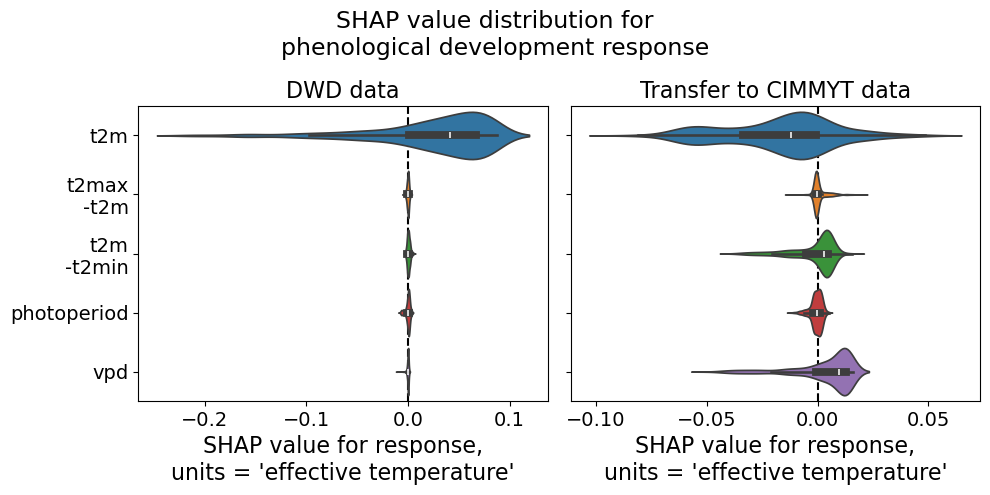

In [89]:
font_size = 14
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
ax = axs[0]
sns.violinplot(data=shap_data_DE, orient = 'h', ax=ax, zorder = 1)
ax.axvline(0, color='k', linestyle='--', zorder = 0)
ax.set_xlabel('SHAP value for response,\nunits = \'effective temperature\'', fontsize = font_size + 2)
ax.set_title('DWD data', fontsize = font_size + 2)
ax.tick_params(labelsize = font_size)
ax = axs[1]
sns.violinplot(data=shap_data_SSA, orient = 'h', ax=ax, zorder = 1)
ax.axvline(0, color='k', linestyle='--', zorder = 0)
ax.set_xlabel('SHAP value for response,\nunits = \'effective temperature\'', fontsize = font_size + 2)
ax.set_title('Transfer to CIMMYT data', fontsize = font_size + 2)
#ax.set_xlim ((-0.005, 0.005))
ax.tick_params(labelsize = font_size, labelleft = False)
fig.suptitle('SHAP value distribution for\nphenological development response', fontsize = font_size + 3)
fig.tight_layout()

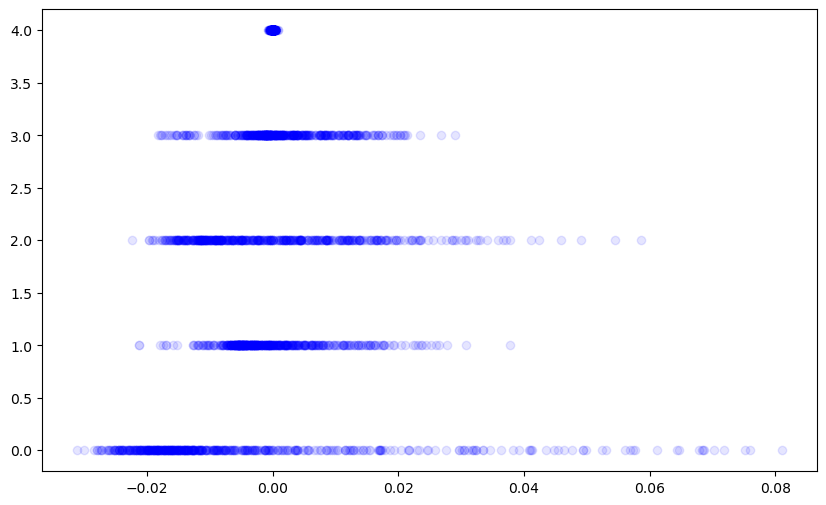

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
for i in range(500):
    ax.scatter(shap_values[i, :, 0], range(5), color='blue', alpha = 0.1)

In [ ]:
shap_values[:10, :, 0]#.shape

array([[ 6.82824109e-02,  2.84006422e-03, -2.31940250e-03,
         1.26184386e-03,  1.54310872e-04],
       [ 5.73895656e-02,  2.22986468e-03, -9.26346744e-03,
         1.56779006e-03,  2.68854289e-04],
       [ 7.02204582e-02, -2.51716762e-03,  6.73983606e-03,
         1.67269487e-03,  8.34354888e-05],
       [ 5.76564885e-02, -1.02558162e-02,  8.75354489e-03,
         1.53836247e-03,  1.86891816e-04],
       [ 7.18201039e-02,  4.03077936e-04,  1.68210769e-03,
         2.07918871e-03,  5.90020436e-05],
       [ 5.67805347e-02, -2.80604175e-03, -3.09014718e-03,
         3.11142573e-03,  2.42049878e-04],
       [ 6.47339784e-02,  5.15290655e-03, -1.33011703e-03,
         3.14026515e-03,  1.19270882e-04],
       [ 5.30776035e-02, -5.31429195e-03, -2.22170711e-03,
         3.81032741e-03,  3.38084897e-04],
       [ 4.98515230e-02, -2.80320597e-05, -8.02876097e-03,
         4.45297730e-03,  2.36533260e-04],
       [ 6.78365679e-02, -2.97004861e-03,  3.05518177e-03,
         3.84831299e-03

In [ ]:
#shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="identity", matplotlib=True)

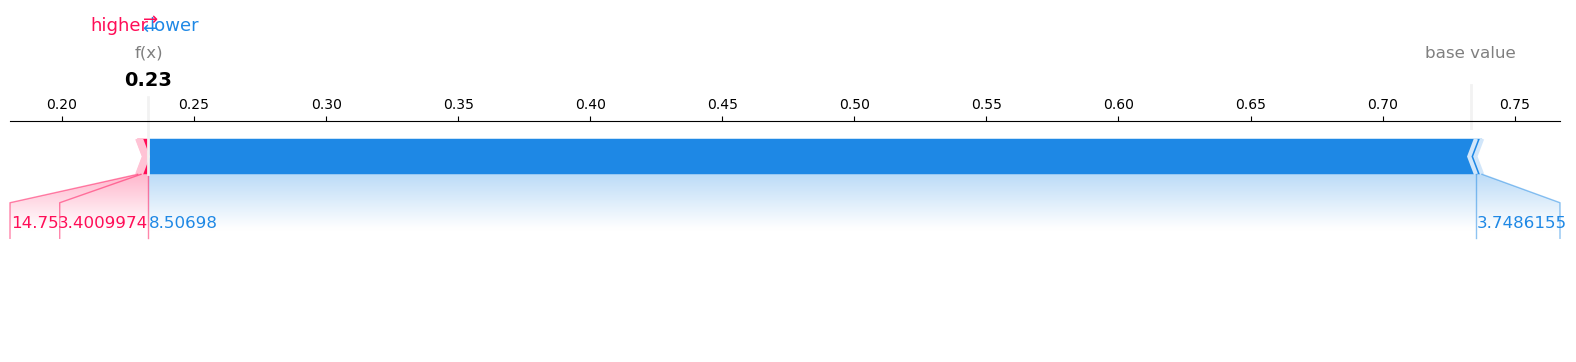

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values[0][:, 0], X_test[0,:], link="identity", matplotlib=True)

In [ ]:
temp_NDVI_series_DE[0, :, 0]

tensor([ 1.1808e+01,  4.9365e+00,  3.4712e+00,  1.5317e+01, -9.1753e-02,
         0.0000e+00,  2.0040e+03,  7.5040e+03])

In [ ]:
shap_wrapper(temp_NDVI_series_DE[0, :, 0].numpy())

array(0.5163244, dtype=float32)

In [ ]:
full_xb.transpose(1, 2).flatten(0, 1).shape

torch.Size([4188285, 8])

In [ ]:
shap_wrapper(full_xb.transpose(1, 2).flatten(0, 1)[0, :].numpy())

array(0.4363166, dtype=float32)

In [ ]:
first_obs = temp_NDVI_series_DE[[0], :, :]
shap_wrapper(first_obs[:, :, [0]])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_16856\2159168050.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return forward_NN_KG2(model, torch.tensor(x).transpose(1, 2)).numpy().squeeze()


array(0.4363166, dtype=float32)

In [ ]:
temp_NDVI_series_DE[[0], :, [0]].shape

torch.Size([1, 8])

In [ ]:
full_xb.transpose(1, 2).flatten(0, 1).numpy().tolist()

[[11.807905197143555,
  4.936478137969971,
  3.4711644649505615,
  15.316666603088379,
  -0.09175340831279755,
  0.0,
  2004.0,
  7504.0],
 [12.635268211364746,
  3.4315671920776367,
  3.3512024879455566,
  15.383333206176758,
  -0.0629304051399231,
  0.10000000149011612,
  2004.0,
  7504.0],
 [12.385751724243164,
  1.7562936544418335,
  2.2121920585632324,
  15.449999809265137,
  -0.038498375564813614,
  0.20000000298023224,
  2004.0,
  7504.0],
 [12.088725090026855,
  4.213867664337158,
  3.832958459854126,
  15.516666412353516,
  -0.04132508486509323,
  0.30000001192092896,
  2004.0,
  7504.0],
 [12.15213680267334,
  1.7578164339065552,
  1.987287163734436,
  15.583333015441895,
  -0.04789603874087334,
  0.4000000059604645,
  2004.0,
  7504.0],
 [10.992865562438965,
  1.2796375751495361,
  1.5075225830078125,
  15.649999618530273,
  -0.07600841671228409,
  0.5,
  2004.0,
  7504.0],
 [13.131155967712402,
  4.296525478363037,
  3.789597749710083,
  15.683333396911621,
  -0.05716870725

In [ ]:
full_xb_val.shape

torch.Size([1448, 8, 163])

In [ ]:
model.fc.weight.data

tensor([[1., 0., 0., 0.]])

In [ ]:
model.layer12.weight.data

tensor([[1., 0.],
        [0., 1.]])